In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb

from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'#'

start @ Wed Jun  8 09:59:19 2022#


In [3]:
print katcali.__version__

1.0.0


In [4]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
input_file1='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/'
input_file2='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level2/data/'

# Select an observation block and load basic information in


In [6]:
fname='1631659886'

data=kio.load_data(fname)
#print data
#print data.obs_script_log

In [7]:
#show the calibrator and bad ants information
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: []


In [8]:
ants_good=[]
for i in np.array(kio.ant_list(data)):
    if i not in bad_ants:
        ants_good.append(i)
    else:
        print str(i) + ' is bad'
        
print fname
print ants_good

1631659886
['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm009', 'm010', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm022', 'm023', 'm024', 'm025', 'm026', 'm030', 'm031', 'm032', 'm033', 'm034', 'm035', 'm036', 'm037', 'm038', 'm039', 'm040', 'm041', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm053', 'm054', 'm055', 'm056', 'm057', 'm058', 'm059', 'm061', 'm062', 'm063']


# Select ant and polarization, then load data in 

In [9]:
#select ant, polarization, and one channel to show data calibration
ant='m010'
pol='h'
ch_plot=800


In [10]:
ch_ref=800
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print corr_id,recv

vis,flags= kio.call_vis(fname,recv)
vis_backup=vis.copy()
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
dump_period=data.dump_period
ang_deg=kio.load_ang_deg(ra,dec,c0)
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)
dp_sb,dp_se=dp_ss[0],dp_ss[-1]

nd_on_time,nd_cycle,nd_set=kd.cal_nd_basic_para(fname)
print nd_on_time,nd_cycle,nd_set
nd_on_edge,nd_off_edge=kd.cal_nd_edges(timestamps,nd_set,nd_cycle,nd_on_time)
print len(nd_on_edge),len(nd_off_edge)
nd_ratio,nd_0, nd_1x=kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, dump_period)

nd_t0,nd_t1x,nd_s0,nd_s1x,nd_t0_ca,nd_t0_cb,nd_t1x_ca,nd_t1x_cb=kl.cal_label_intersec(dp_tt,dp_ss,nd_0,nd_1x)
labels_1x=kl.cal_label_intersec_complex(dp_tt,dp_ss,nd_0,nd_1x,nd_ratio)

0 m010h
['m010h' 'm010h']
0.584752616075 19.4917538692 1631659886.03
edge number 0-388
389 389
*** diode 0 was fired out of timestamps list: -81.0646858215 not in [0,7486.83263993]
*** diode 1 was fired out of timestamps list: -61.5729320049 not in [0,7486.83263993]
*** diode 2 was fired out of timestamps list: -42.0811781883 not in [0,7486.83263993]
*** diode 3 was fired out of timestamps list: -22.5894241333 not in [0,7486.83263993]
*** diode 4 was fired out of timestamps list: -3.0976703167 not in [0,7486.83263993]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)
[0.0, 0.04949, 0.24301, 0.2925]
# nd ratio number in total: 4
ratio1 0.04949 :  84 7 70 7
ratio2 0.24301 :  84 7 70 7
ratio3 0.2925 :  252 21 210 21
# total label groups for nd_1x: 9


In [11]:
ra1=ra.copy()
for i in range(len(ra)):
    if ra[i]>180:
        ra1[i]=ra[i]-360
ra=ra1

In [12]:
p_radec=np.loadtxt('radio_source2021.txt')

ra_a4059,dec_a4059=-0.74042,-34.76056

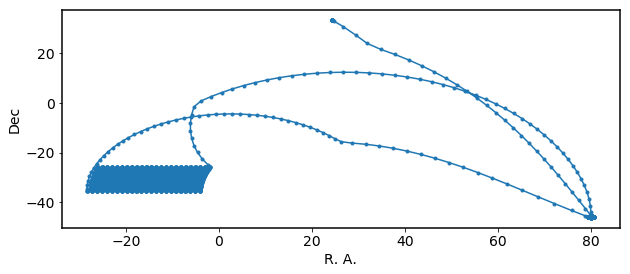

In [13]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra,dec,'.-')
#plt.plot(ra[dp_s],dec[dp_s],'g.')
#plt.plot(ra[dp_tt],dec[dp_tt],'m.')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

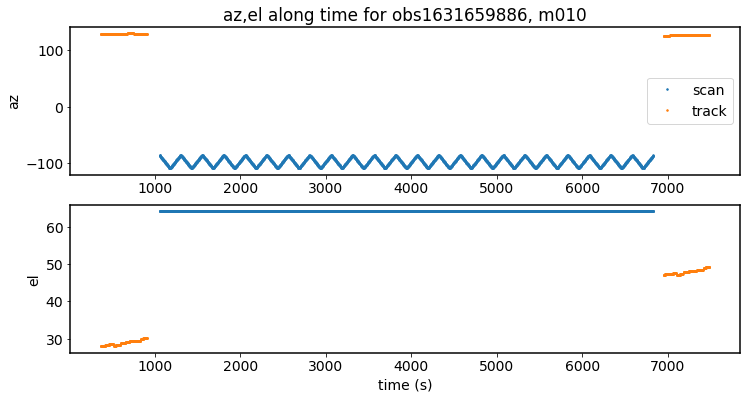

In [14]:
#show the az,el along time
plt.figure(figsize=(12,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az[dp_tt],'.',Markersize=3)
#plt.xlabel('time (s)')
plt.ylabel('az')
plt.title('az,el along time for obs'+str(fname)+', '+str(ant))
plt.legend(['scan','track'])
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf',  bbox_inches='tight')
plt.show()

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


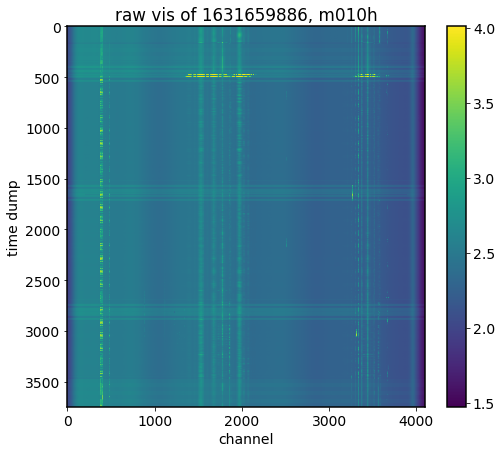

In [15]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(np.log10(vis),aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [16]:
vis1=vis[:,ch_plot]
plt_ymin=vis1.min()
plt_ymax=vis1.max()

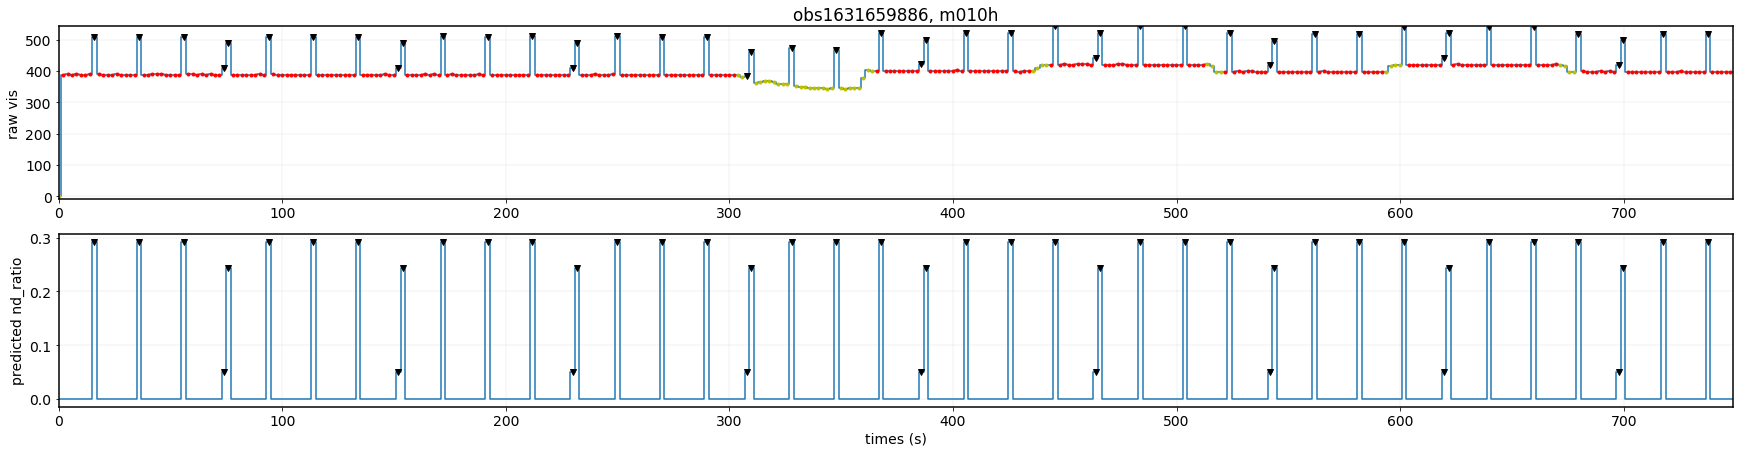

x-axis is time (s)


In [17]:
x_min=(timestamps[-1]-timestamps[0])*.0
x_max=(timestamps[-1]-timestamps[0])*.1

plt.figure(figsize=(30,7))
plt.subplot(211)
plt.step(timestamps-timestamps[0],vis1,'-',where='mid')
plt.plot(timestamps[dp_t]-timestamps[0],vis1[dp_t],'r.')
plt.plot(timestamps[dp_s]-timestamps[0],vis1[dp_s],'m.')
plt.plot(timestamps[dp_stop]-timestamps[0],vis1[dp_stop],'g.')
plt.plot(timestamps[dp_slew]-timestamps[0],vis1[dp_slew],'y.')
plt.plot(timestamps[nd_1x]-timestamps[0],vis1[nd_1x],'kv')
#plt.xticks(np.arange(0, timestamps[-1]-timestamps[0], 10))
plt.grid(color='grey',lw=.1)
#plt.xlabel('times (s)')
plt.ylabel('raw vis')
plt.xlim(x_min,x_max)
plt.ylim(plt_ymin-10,plt_ymax)
plt.title('obs'+fname+', '+recv)
plt.subplot(212)
plt.step(timestamps-timestamps[0],nd_ratio,'-',where='mid')
plt.plot(timestamps[nd_1x]-timestamps[0],nd_ratio[nd_1x],'kv')
#plt.xticks(np.arange(0, timestamps[-1]-timestamps[0], 10))
plt.grid(color='grey',lw=.1)
plt.xlabel('times (s)')
plt.ylabel('predicted nd_ratio')
plt.xlim(x_min,x_max)
plt.show()

print 'x-axis is time (s)'

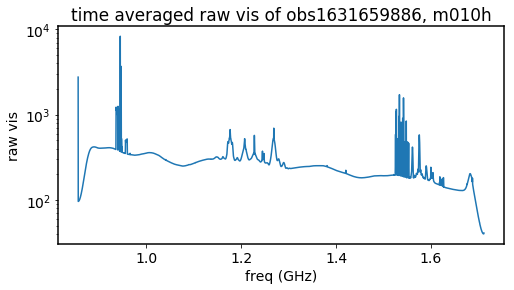

In [18]:
##time mean raw vis to show the bandpass
plt.figure(figsize=(8,4))
plt.plot(freqs/1e9,np.mean(vis[nd_0,:],axis=0))
plt.xlabel('freq (GHz)')
plt.ylabel('raw vis')
plt.yscale('log')
plt.title('time averaged raw vis of obs'+str(fname)+', '+str(recv))
plt.savefig('band_mean.pdf', bbox_inches='tight')
plt.show()

In [19]:
p = SkyCoord(data.ra*u.deg,  data.dec*u.deg, frame='icrs')
ang_lim=.5

dp_ptr_list=kl.cal_ptr_mask(p,p_radec,nd_s0, dp_sb,dp_se,ang_lim)


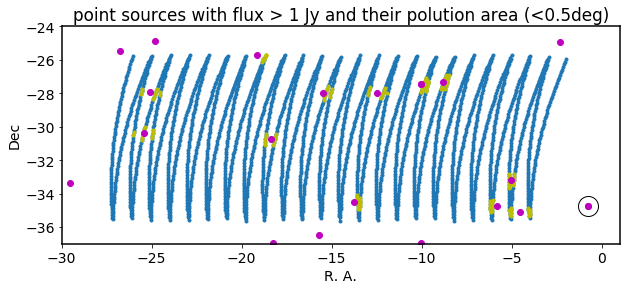

In [20]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra[dp_s],dec[dp_s],'.-')
plt.plot(ra[dp_ptr_list],dec[dp_ptr_list],'y.')
plt.plot(ra_a4059,dec_a4059,color='k',marker='o',markerfacecolor='none',ms=20)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.xlim(-30,1)
plt.ylim(-37,-24)
plt.title('point sources with flux > 1 Jy and their polution area (<'+str(ang_lim)+'deg)')
plt.show()


# RFI flagging

In [21]:
#check with .py result
try:
    d3 = pickle.load(open(input_file1+fname+'_'+ant+'_mask2'))
    print '# mask2 loaded'
except(Exception):
    d3 = pickle.load(open(input_file1+fname+'_'+ant+'_mask'))
    print '# mask loaded'
                          
mask_inter=d3['mask']
vis_clean=np.ma.array(vis,mask=mask_inter)


# mask loaded


/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


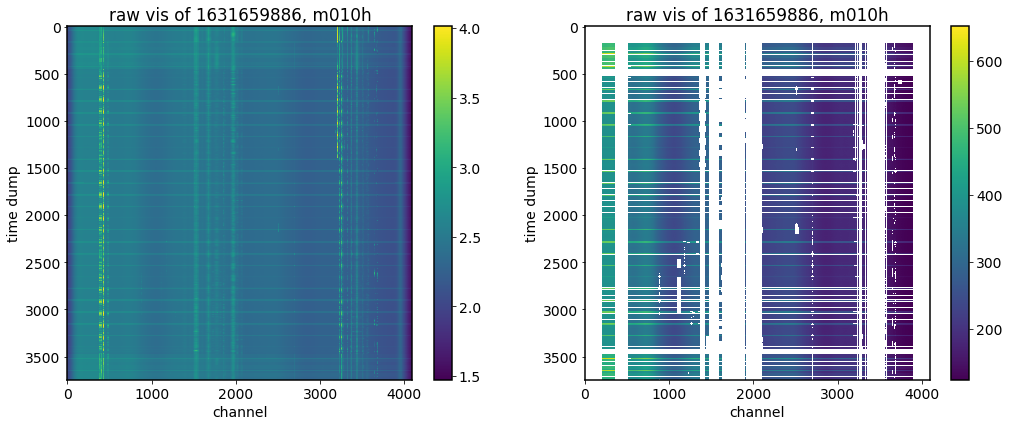

In [22]:
#raw visibility
plt.figure(figsize=(17,6.5))
plt.subplot(121)
plt.imshow(np.log10(vis),aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.show()

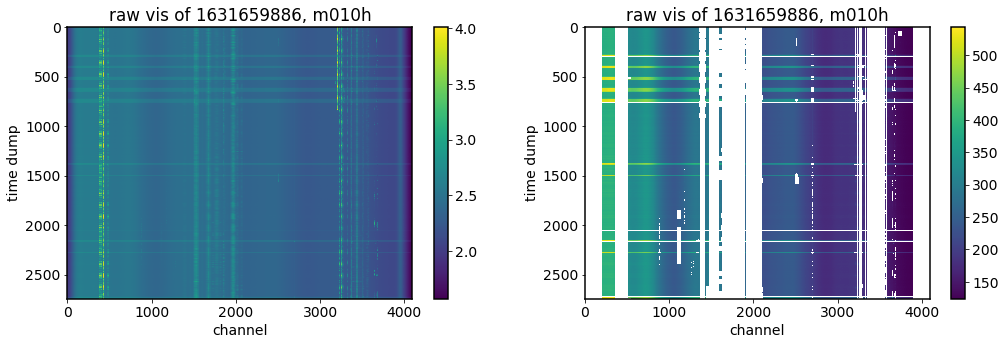

In [23]:
#raw visibility
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.imshow(np.log10(vis[dp_ss,:]),aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean[dp_ss,:],aspect='auto')
plt.ylabel('time dump')
plt.xlabel('channel')
plt.title('raw vis of '+str(fname)+', '+str(recv))
plt.colorbar()
plt.show()

## load the foreground models

In [24]:
dp_u=kl.cal_dp_u(dp_tt,dp_ss)

#cal_Tspill is for single channel only! cal_Tspill_func has higher efficiency for multi channel calibration


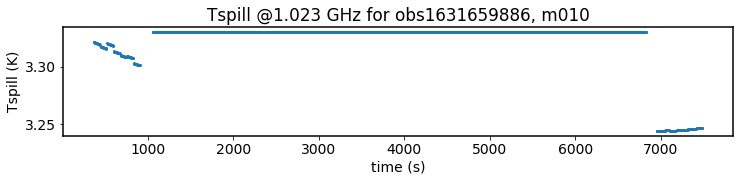

In [25]:
#spill model 
Tspill=km.cal_Tspill(el,pol,freqs, ch_plot,2) #fixed version

plt.figure(figsize=(12,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tspill[dp_u],'.', ms=3)
plt.title('Tspill @'+str(round(freqs[ch_plot]/1e9,3)) +' GHz for obs'+fname+', '+ant)
plt.xlabel('time (s)')
plt.ylabel('Tspill (K)')
plt.show()

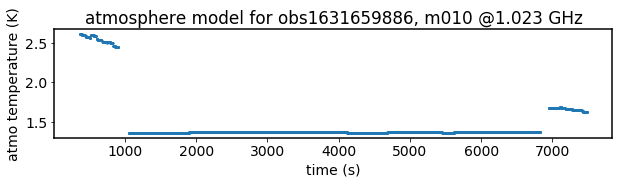

In [26]:
#atmosphere emission model
Tatmo=km.calc_atmosphere_model_1ch(data,ch_plot)

plt.figure(figsize=(10,2))
plt.plot(timestamps[dp_u]-timestamps[0],Tatmo[dp_u],'.', ms=3)
plt.xlabel('time (s)')
plt.ylabel('atmo temperature (K)')
plt.title('atmosphere model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

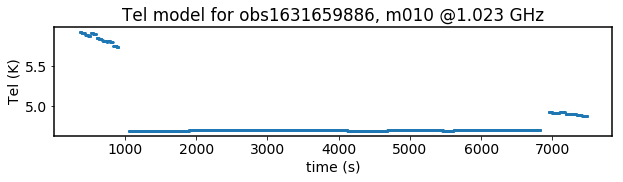

In [27]:
#elevation related emission model
Tel=Tspill+Tatmo 

plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_u]-data.timestamps[0],Tel[dp_u],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tel (K)')
plt.title('Tel model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

l 4014


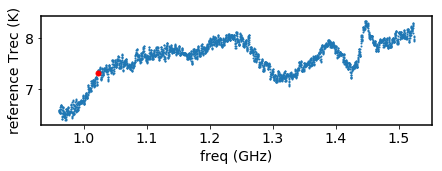

In [28]:
Trec_list=km.cal_Trec(data,ant,pol,freqs)

plt.figure(figsize=(7,2))
plt.plot(freqs[500:3200]/1e9,Trec_list[500:3200],'.',ms=2)
plt.plot(freqs[ch_plot]/1e9,Trec_list[ch_plot],'ro',ms=5)
plt.xlabel('freq (GHz)')
plt.ylabel('reference Trec (K)')
plt.show()

In [29]:
#Galactic model
nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
#gal_ori=km.cal_Gal_model_np(vis, freqs, ra, dec, ch_plot, ch_plot+1, nside)
gal_ori=km.cal_Gal_model_np2(vis, freqs, ra, dec, 0, len(freqs), nside, model_key=-1)
print '#Gal model is from Halsam!!!'
gal_ori.flags.writeable=False #avoid change by mistake
Tgal=gal_ori[:,ch_plot]


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
# haslam408_dsds_Remazeilles2014.fits loaded...
# synch_beta.fits loaded...
(3145728,) (49152,)
#Gal model is from Halsam!!!


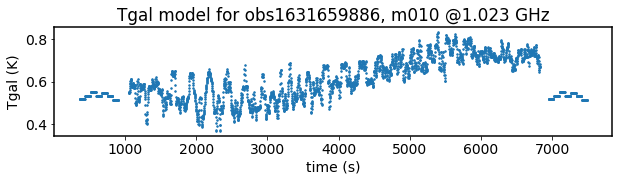

In [30]:
plt.figure(figsize=(10,2))
plt.plot(data.timestamps[dp_u]-data.timestamps[0],Tgal[dp_u],'.',ms=3)
plt.xlabel('time (s)')
plt.ylabel('Tgal (K)')
plt.title('Tgal model for obs'+str(fname)+', '+str(ant)+' @'+str(round(data.freqs[ch_plot]/1e9,3))+' GHz')
plt.show()

<type 'numpy.ndarray'>


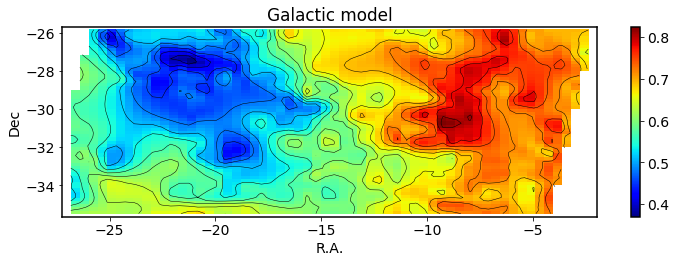

In [31]:
#check Galactic model
p_data=Tgal[dp_sb:dp_se+1]
plt.figure(figsize=(12,3.5))
kv.plot_data(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], p_data,gsize=60)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Galactic model')
plt.show()

In [32]:
d2=pickle.load(open(input_file2+fname+'_'+str(recv)+'_level2_Tnd_data'))
print d2.keys()

['Tnd_ref_list', 'Tndb_list', 'Tnda_list']


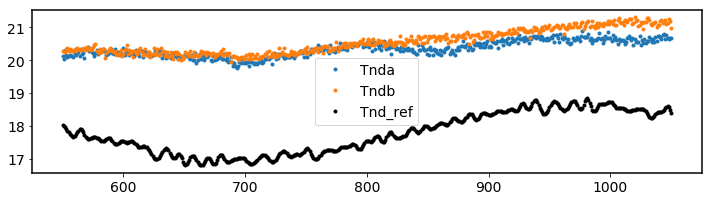

In [33]:
Tnda_list=d2['Tnda_list']
Tndb_list=d2['Tndb_list']
Tnd_ref_list=d2['Tnd_ref_list']
plt.figure(figsize=(12,3))
plt.plot(Tnda_list,'.')
plt.plot(Tndb_list,'.')
plt.plot(Tnd_ref_list,'k.')
plt.legend(['Tnda','Tndb','Tnd_ref'])
plt.show()

In [34]:
###set input params
Tnda=Tnda_list[ch_plot]
Tndb=Tndb_list[ch_plot]

if abs(Tnda-Tndb)<1:
    Tnd=(Tnda+Tndb)/2.

print Tnda,Tndb,Tnd
assert(isinstance(Tnd,np.float))

20.5137674348 20.4739249098 20.4938461723


# calibration for scan part

In [35]:
###raw vis preparsion
vis_clean_tt=vis_clean.copy()
vis_clean_tt.mask[:dp_sb,:]=True
vis_clean_tt.mask[dp_se+1:,:]=True
        
####param0
g0=10.
Tptr=0 #no point source
eta_p0=1.0
Trec0=Trec_list[ch_plot]
func_sm_param0=[Trec0,0,0,0]
func_gt_param0=[g0,0,0,0,0]#must be [-5:] from func_obj_sm


##fitting
instru_p=ks.solve_params_sm_v3(timestamps, vis_clean_tt, ch_plot, nd_ratio, Tptr, eta_p0, Tnd, Tel, Tgal,
                      func_gt_param0, func_sm_param0, nd_0, nd_1x)

###output
eta_p=instru_p[0]
sm=instru_p[1:-5]
gt=instru_p[-5:] 
print eta_p, sm, gt

Optimization terminated successfully.
         Current function value: 13541.799724
         Iterations: 51
         Function evaluations: 9426
1.0 [  8.12965113e+00   6.18087544e-03  -4.01418271e-02   4.77655156e-03] [  2.01753911e+01  -4.16376778e-02   1.84067531e-01   1.48401050e-02
   1.54825538e-01]


In [36]:
print Trec0

7.31736450195


-0.00263507618568 0.0644930996232


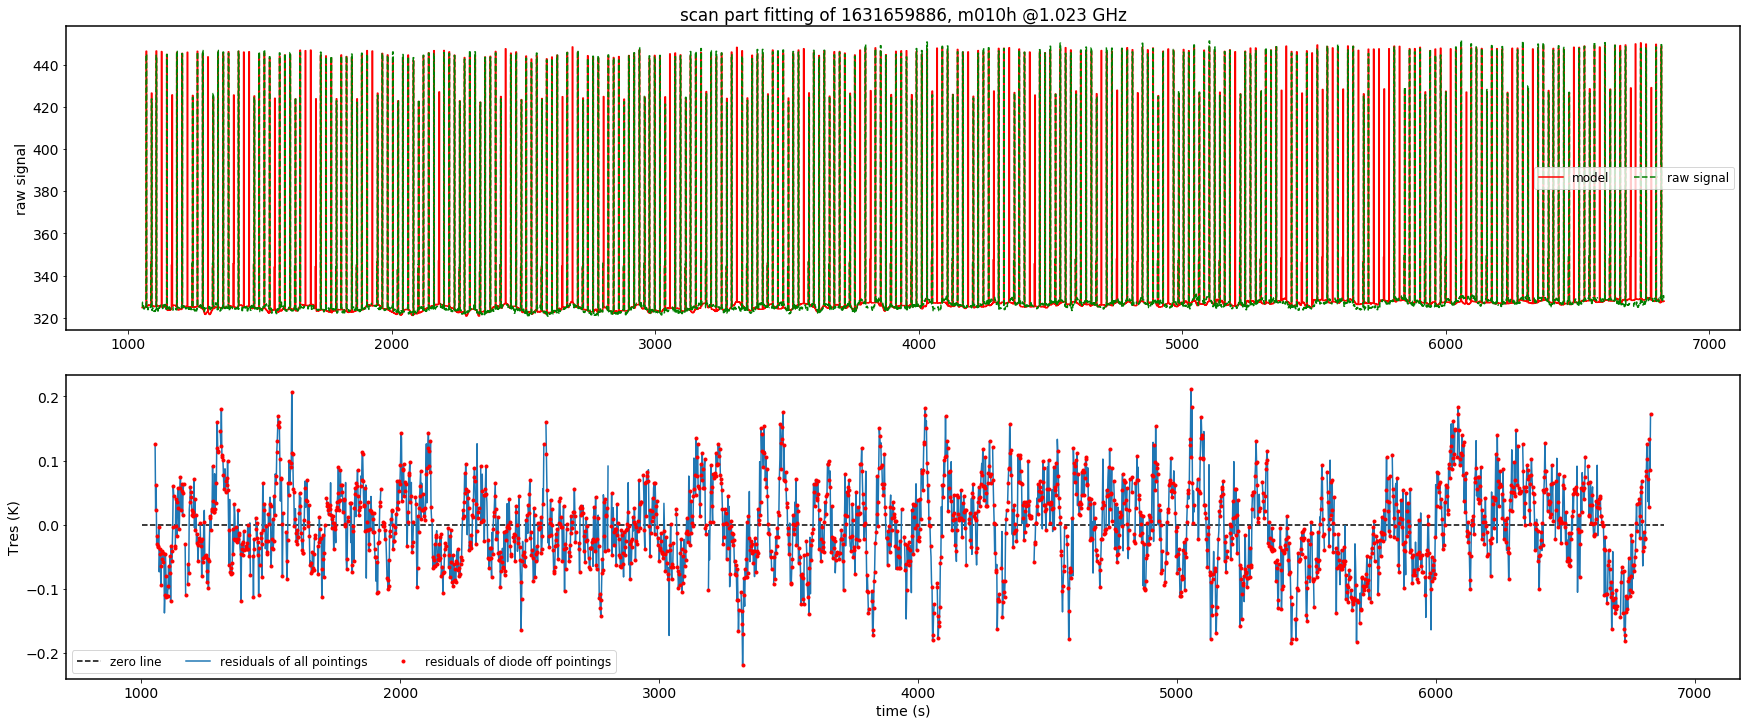

In [37]:
#fitted model and raw vis
# calc_total_model_sm for scan, calc_total_model for calibrator
m=ks.calc_total_model_sm_v3(timestamps, nd_ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1x)

#plt.figure(figsize=(20,5))
#'''
plt.figure(figsize=(30,12))
plt.subplots_adjust(wspace =0, hspace =0.15)
plt.subplot(211)
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],m[dp_sb:dp_se+1],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],vis_clean[dp_sb:dp_se+1,ch_plot],'g--',drawstyle='steps-mid')
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
if fname=='1551055211':
    plt.title('Fitting curve of scan at '+ str(int(freqs[ch_plot]/1e6)) +' MHz, '+str(recv)+' of obs190225')
    plt.ylim(125,250)
plt.legend(['model','raw signal'],ncol=2,fontsize=12)
#plt.xlim(1100,1400)
#plt.savefig('cali_scan.pdf')
plt.subplot(212)
#'''
#residual curve
residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
print np.mean(residual[nd_s0]),np.std(residual[nd_s0])
plt.plot([timestamps[dp_sb]-timestamps[0]-50,timestamps[dp_se+1]-timestamps[0]+50],[0,0],'k--')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0], residual[dp_sb:dp_se+1])
plt.plot(timestamps[nd_s0]-timestamps[0], residual[nd_s0],'r.')
plt.xlabel('time (s)')
plt.ylabel('Tres (K)')
#plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
#plt.ylim(-0.25,0.25)
plt.legend(['zero line','residuals of all pointings', 'residuals of diode off pointings'],ncol=3,fontsize=12)
plt.savefig('F_'+fname+'_cali_scan.pdf', bbox_inches='tight')
plt.show()

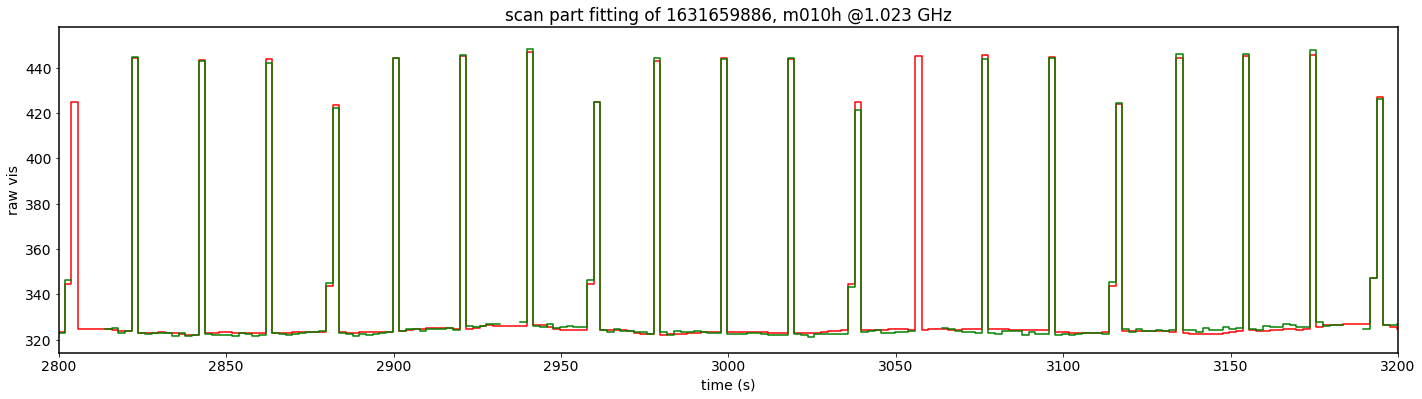

In [38]:
#enlarge of above
plt.figure(figsize=(24,6))
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],m[dp_sb:dp_se+1],'r-',where='mid')
plt.step(timestamps[dp_sb:dp_se+1]-timestamps[0],vis_clean[dp_sb:dp_se+1,ch_plot],'g-',where='mid')
plt.xlabel('time (s)')
plt.ylabel('raw vis')
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.xlim(2800,3200)
plt.show()

-0.00263507618568 0.0644930996232


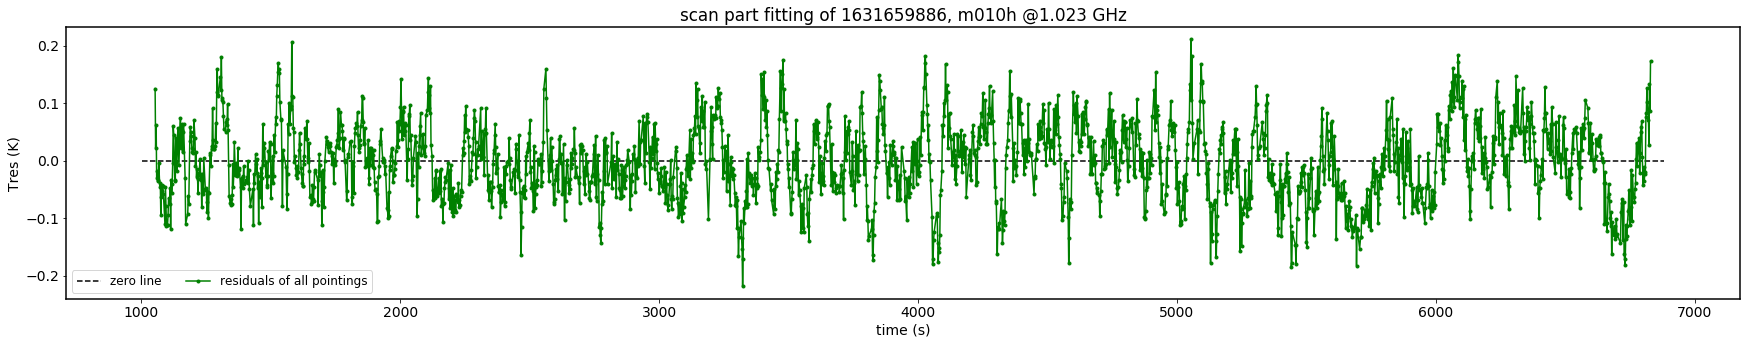

In [39]:
#fitted model and raw vis
# calc_total_model_sm for scan, calc_total_model for calibrator
m=ks.calc_total_model_sm_v3(timestamps, nd_ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1x)

plt.figure(figsize=(30,5))
'''
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace =0, hspace =0.15)
plt.subplot(211)
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],m[dp_sb:dp_se+1],'r-',drawstyle='steps-mid')
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],vis_clean[dp_sb:dp_se+1,ch_plot],'g--',drawstyle='steps-mid')
#plt.xlabel('time (s)')
plt.ylabel('raw signal')
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
if fname=='1551055211':
    plt.title('Fitting curve of scan at '+ str(int(freqs[ch_plot]/1e6)) +' MHz, '+str(recv)+' of obs190225')
    plt.ylim(125,250)
plt.legend(['model','raw signal'],ncol=2,fontsize=12)
#plt.xlim(1100,1400)
#plt.savefig('cali_scan.pdf')
plt.subplot(212)
'''
#residual curve
residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
print np.mean(residual[nd_s0]),np.std(residual[nd_s0])
plt.plot([timestamps[dp_sb]-timestamps[0]-50,timestamps[dp_se+1]-timestamps[0]+50],[0,0],'k--')
#plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0], residual[dp_sb:dp_se+1])
plt.plot(timestamps[nd_s0]-timestamps[0], residual[nd_s0],'g.-')
plt.xlabel('time (s)')
plt.ylabel('Tres (K)')
plt.title('scan part fitting of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
#plt.ylim(-0.25,0.25)
plt.legend(['zero line','residuals of all pointings', 'residuals of diode off pointings'],ncol=3,fontsize=12)
#plt.savefig('F_'+fname+'_cali_scan.pdf', bbox_inches='tight')
#plt.xlim(3500,3600)
plt.show()

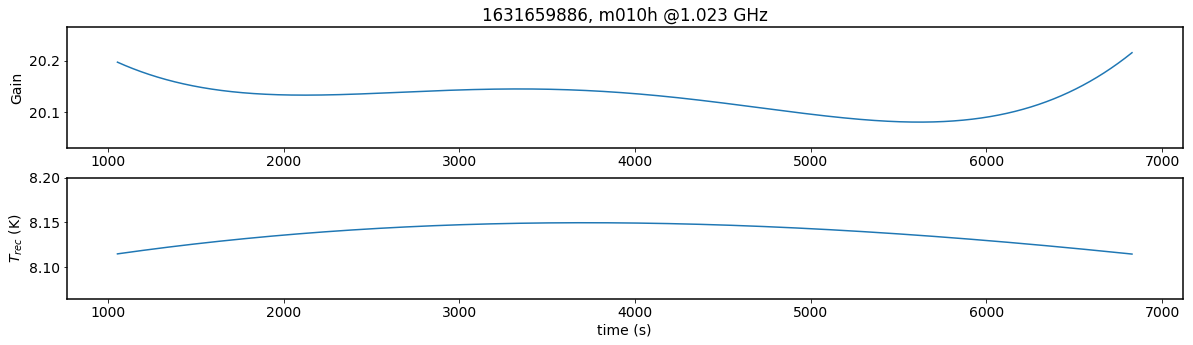

In [40]:
#curves for fitted params
plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace =0, hspace =0.25)
plt.subplot(211)
gt_plot=ks.func_gt(timestamps,gt)[dp_sb:dp_se+1]
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],gt_plot)
plt.ylim(gt_plot.min()-0.05, gt_plot.max()+0.05)
#plt.xlabel('time (s)')
plt.ylabel('Gain')
plt.title(str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
if fname=='1551055211':
    plt.title('Parameter curves of scan at '+ str(int(freqs[ch_plot]/1e6)) +' MHz, '+str(recv)+' of obs190225')
plt.subplot(212)
sm_plot=ks.func_sm(timestamps,sm)[dp_sb:dp_se+1]
#plt.plot(timestamps[nt_scan_b:nt_scan_e+1]-timestamps[0],func_sm_break_long(timestamps,sm,nt_az_edge)[nt_scan_b:nt_scan_e+1])
plt.plot(timestamps[dp_sb:dp_se+1]-timestamps[0],sm_plot)
plt.ylim(sm_plot.min()-0.05, sm_plot.max()+0.05)
plt.xlabel('time (s)')
plt.ylabel(r'$T_{rec}$'+' (K)')
plt.savefig('F_'+fname+'_gt_sm_curves.pdf', bbox_inches='tight')
plt.show()

<type 'numpy.ndarray'>


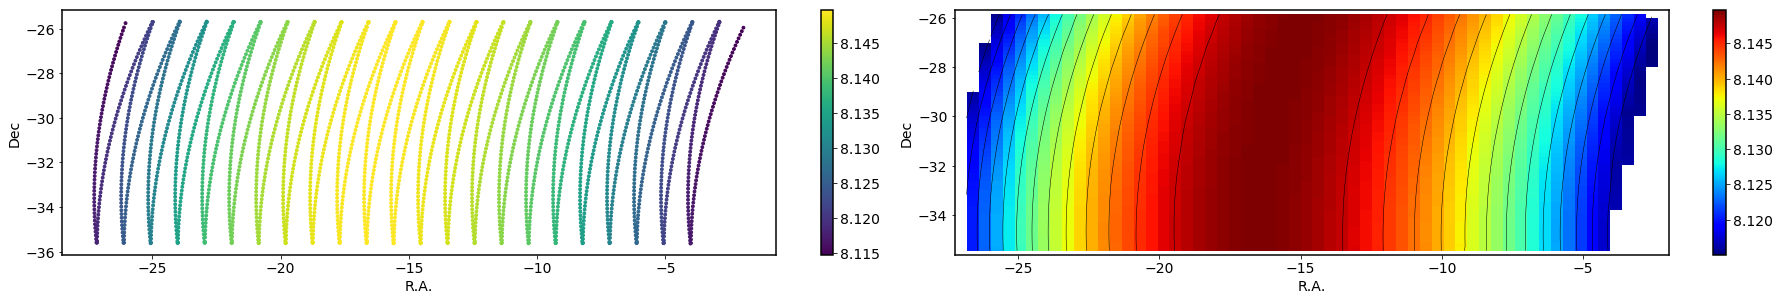

In [41]:
###check the smooth on 2D map
plot_gsize=60
plt.figure(figsize=(32,4.5))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=ks.func_sm(timestamps,sm)[dp_sb:dp_se+1]
plt.scatter(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.colorbar()
plt.subplot(122)
p_data=ks.func_sm(timestamps,sm)[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


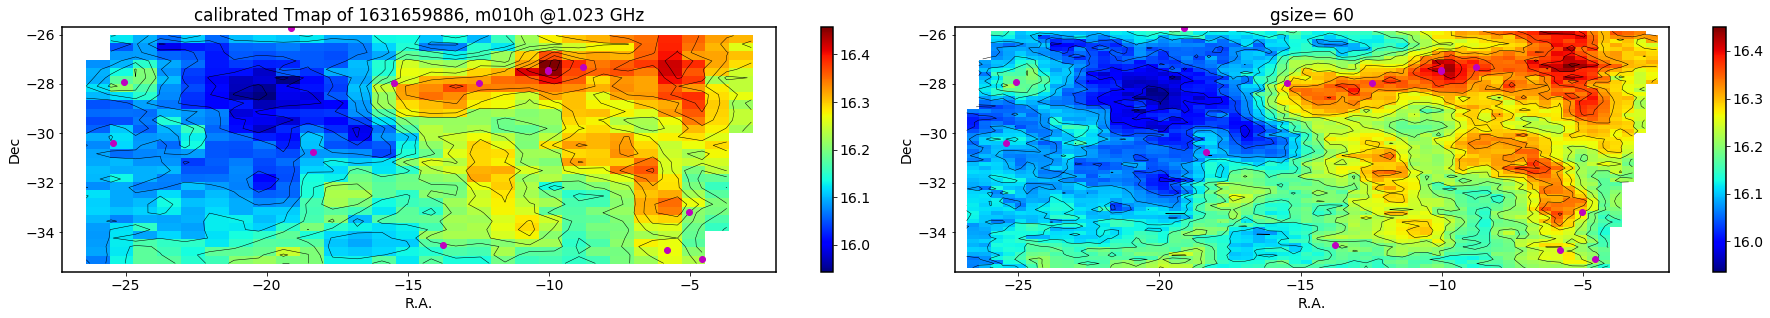

In [42]:
##calibrated map in two resolution
T=vis_clean[:,ch_plot]/ks.func_gt(timestamps,gt)
p_data=T[nd_s0]
plt.figure(figsize=(32,4.5))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz')
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.subplot(122)
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('gsize= '+str(plot_gsize))
plt.xlabel('R.A.')
plt.ylabel('Dec')
#plt.savefig(str(fname)+'_'+str(recv)+'_map_calibrated.pdf',bbox_inches='tight')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<type 'numpy.ndarray'>


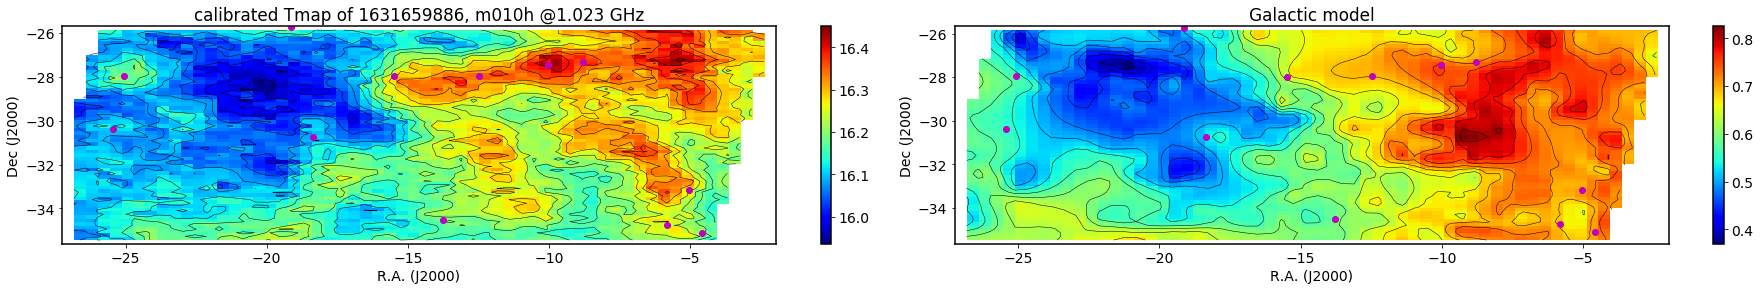

In [43]:
#calibrated map vis Galactic map
plt.figure(figsize=(32,4))
plt.subplots_adjust(wspace =0, hspace =0)
plt.subplot(121)
p_data=T[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=60)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.subplot(122)
p_data=Tgal[dp_sb:dp_se+1]
kv.plot_data(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], p_data,gsize=60)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title('Galactic model')
#plt.savefig('calibrated_map1.pdf')
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


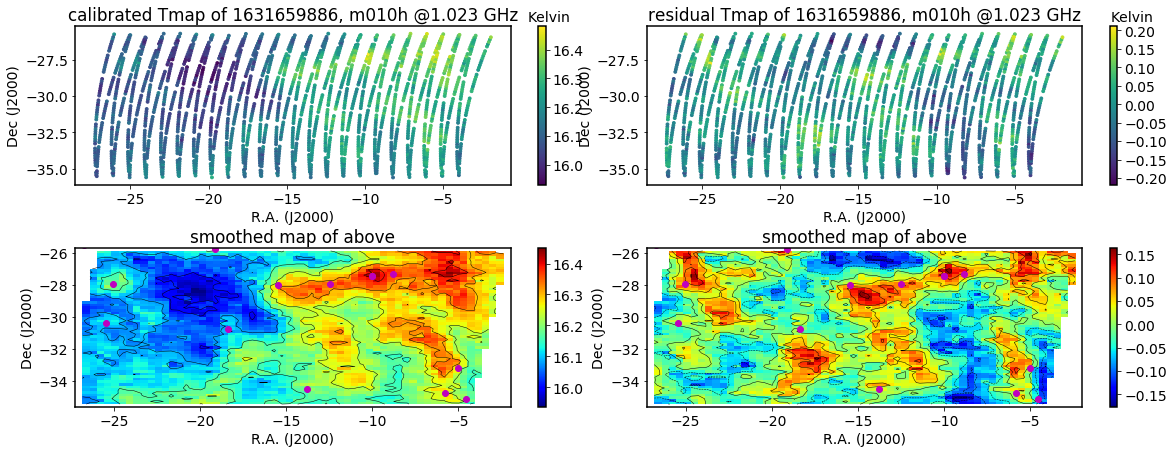

In [44]:
#residual map in different resolution
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.05,hspace=.4)
plt.subplot(221)
p_data=T[nd_s0]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
plt.subplot(222)
p_data=residual[nd_s0]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8)
plt.title('residual Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
plt.subplot(223)
p_data=T[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize,levels=6)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
#plt.text(181.5, 8.5, 'Kelvin', rotation=0)
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.subplot(224)
p_data=residual[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize,levels=6)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
#plt.text(181.5, 8.5, 'Kelvin', rotation=0)
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
#plt.savefig('calibrated_map.pdf', bbox_inches='tight')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


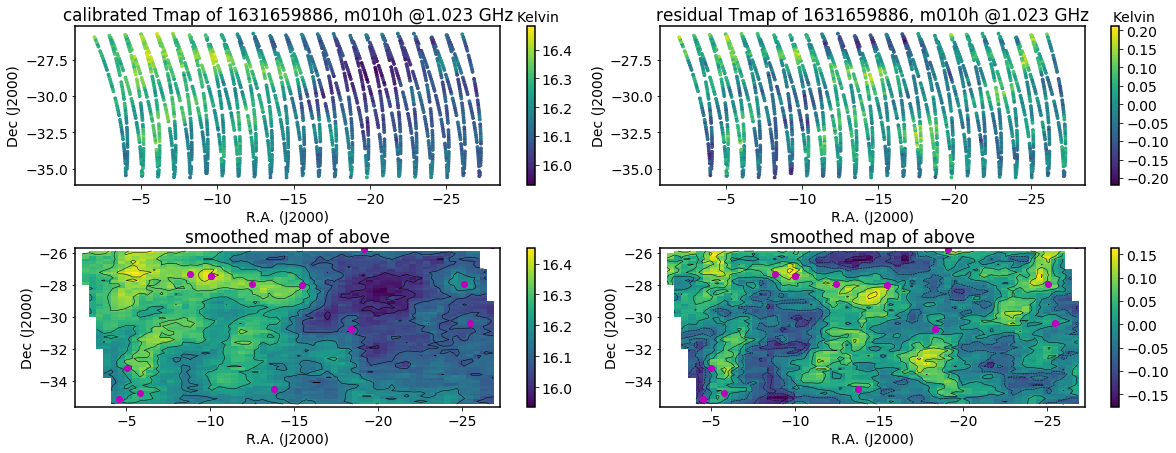

In [45]:

#residual map in different resolution
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.1,hspace=.4)
ax=plt.subplot(221)
p_data=T[nd_s0]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('calibrated Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
if fname=='1551055211':
    plt.title('$T_{cal}$ map at '+str(int(freqs[ch_plot]/1e6))+' MHz, '+recv+' of obs190225')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(222)
p_data=residual[nd_s0]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('residual Tmap of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
if fname=='1551055211':
    plt.title('$T_{res}$ map at '+str(int(freqs[ch_plot]/1e6))+' MHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(223)
p_data=T[nd_s0]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
#plt.text(146.3, 8.5, 'Kelvin', rotation=0)
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
ax=plt.subplot(224)
p_data=residual[nd_s0]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
#plt.text(146.3, 8.5, 'Kelvin', rotation=0)
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
#plt.savefig('F_calibrated_map.pdf', bbox_inches='tight')
plt.show()

<type 'numpy.ndarray'>


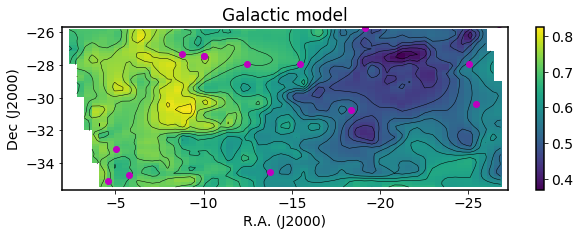

In [46]:
#calibrated map vis Galactic map
plt.figure(figsize=(10,3))
ax=plt.subplot()
p_data=Tgal[dp_sb:dp_se+1]
kv.plot_data(ra[dp_sb:dp_se+1],dec[dp_sb:dp_se+1], p_data,gsize=60, cmap=kv.cmap1())
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
plt.title('Galactic model')
ax.invert_xaxis()
plt.show()


In [47]:
gain=ks.func_gt(timestamps,gt)
Tsm=ks.func_sm(timestamps,sm)
print gain[dp_sb:dp_se+1].mean(),gain[dp_sb:dp_se+1].std()
print m[dp_sb:dp_se+1].mean(),m[dp_sb:dp_se+1].std()
print T[nd_s0].mean(),T[nd_s0].std()
print residual[nd_s0].mean(),residual[nd_s0].std()

20.128221352 0.0281059025493
338.029127437 35.1551532995
16.1762650067 0.106128094258
-0.00263507618568 0.0644930996232


In [48]:
print pol,recv
assert(recv[-1]==pol)

h m010h


In [49]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jun  8 10:00:37 2022#
